In [1]:
from learningAgent import LearningAlgorithm
from environment import Model, AdversaryModes
from Qtable import QTable
from test import Test
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
np.random.seed(11)

In [3]:
total_demand = 400
agent_cost = 57
adversary_cost = 71 
costs = [agent_cost,adversary_cost]
total_stages = 25
adversary_probabilities=[0]*len(AdversaryModes)
# Below is where we decide what adversaries we train against. See environment.py for the numbers
adversary_probabilities[3]= 0.5
adversary_probabilities[10] = 0.5
game = Model(total_demand, costs, total_stages, adversary_probabilities)

In [4]:
number_actions = 50
number_demands = total_demand + 1
discount_factor = 1
number_episodes = 100_000_000
constant = int(number_episodes/49)
print(constant)

2040816


In [5]:
# Learning rate is given as [numerator,denominator] which gives us a learning rate function of 
# numerator/(n+denominator)
Qtable = QTable(number_demands, number_actions, total_stages , learning_rate = [constant,constant])

In [6]:
algorithm = LearningAlgorithm(game, Qtable, number_episodes, discount_factor)

In [7]:
# Below is the first stage of learning: actions are chosen randomly.
number_episodes_per_round = 100_000
number_rounds = int(number_episodes / number_episodes_per_round)
errors = np.zeros(number_rounds)
final_round = 0
opponent_results = [list() for mode in AdversaryModes]
for round_ in range(number_rounds):
    algorithm.continue_learning(number_episodes_per_round,number_episodes_per_round * round_ +1)

    result = Test(game, Qtable, discount_factor, adversary_probabilities)
    errors[round_] = result.error(1000)
    if errors[round_] < 0.01 or (round_ * number_episodes_per_round > 0.1 * number_episodes):
        print(round_)
        final_round = round_
        break
    if round_ % 5 == 0:
        print("Round:", round_, "Errors:", errors[round_])

    for index, adversary in enumerate(AdversaryModes):
        if adversary_probabilities[index] > 0:
            new_adversary_probabilities =[0]*len(AdversaryModes)
            new_adversary_probabilities[index] = 1
            result = Test(game, Qtable, discount_factor, new_adversary_probabilities)
            payoff, _, _, _, _ = result.total_payoff()
            opponent_results[index].append(payoff)
            if round_ % 5 == 0:
                print('Current payoff against', adversary.name, ":" , payoff)

    if round_ == number_rounds - 1:
        final_round = round_
    
plt.plot(errors[0:final_round+1])

Round: 0 Errors: 0.22765260584495642
Current payoff against imitation_132 : 130390.0
Current payoff against guess_132 : 72659.0
Round: 5 Errors: 0.15171548618205044
Current payoff against imitation_132 : 131170.0
Current payoff against guess_132 : 101447.0
Round: 10 Errors: 0.10180678462202265
Current payoff against imitation_132 : 130140.0
Current payoff against guess_132 : 105181.0
Round: 15 Errors: 0.08699562465937928
Current payoff against imitation_132 : 131097.0
Current payoff against guess_132 : 99688.0
Round: 20 Errors: 0.08146668519691855
Current payoff against imitation_132 : 131077.0
Current payoff against guess_132 : 105613.0
Round: 25 Errors: 0.07175203174671972
Current payoff against imitation_132 : 131708.0
Current payoff against guess_132 : 104855.0
Round: 30 Errors: 0.0728718381065922
Current payoff against imitation_132 : 131708.0
Current payoff against guess_132 : 101946.0
Round: 35 Errors: 0.07150256021003719
Current payoff against imitation_132 : 131708.0
Current p

KeyboardInterrupt: 

In [8]:
# Below is the second stage of learning: actions are chosen according to an epsilon greedy strategy.
episode_counter = (final_round + 1) * number_episodes_per_round
episodes_left = number_episodes - episode_counter
number_episodes_per_round = 500_000
number_rounds = int(episodes_left / number_episodes_per_round)

for round_ in range(number_rounds): 
    print('Round ', round_, ' of ', number_rounds)
    algorithm.epsilon_greedy_learning(number_episodes_per_round, episode_counter)

    for index, adversary in enumerate(AdversaryModes):
        if adversary_probabilities[index] > 0:
            new_adversary_probabilities =[0]*len(AdversaryModes)
            new_adversary_probabilities[index] = 1
            result = Test(game, Qtable, discount_factor, new_adversary_probabilities)
            payoff, _, _, _, _ = result.total_payoff()
            opponent_results[index].append(payoff)
            print('Current payoff against', adversary.name, ":" , payoff)
    
    episode_counter += number_episodes_per_round


Round  0  of  199
Best payoff:  136458
Best actions:  [118, 131, 128, 126, 123, 121, 121, 119, 119, 119, 119, 120, 119, 119, 117, 119, 118, 119, 123, 115, 118, 122, 114, 112, 131]
Current payoff against imitation_132 : 122143.0
Current payoff against guess_132 : 135123.0
Round  1  of  199
Best payoff:  136691
Best actions:  [118, 131, 128, 127, 122, 124, 120, 118, 119, 120, 120, 120, 120, 121, 117, 120, 120, 121, 122, 115, 121, 120, 117, 116, 133]
Current payoff against imitation_132 : 127842.0
Current payoff against guess_132 : 135931.0
Round  2  of  199
Best payoff:  137086
Best actions:  [118, 132, 131, 128, 126, 123, 124, 118, 121, 120, 120, 121, 122, 118, 122, 118, 120, 121, 119, 119, 116, 116, 117, 113, 133]
Current payoff against imitation_132 : 127203.0
Current payoff against guess_132 : 136922.0
Round  3  of  199
Best payoff:  137356
Best actions:  [118, 132, 132, 131, 128, 126, 123, 125, 119, 120, 120, 120, 120, 120, 121, 120, 121, 122, 123, 119, 120, 118, 116, 116, 132]
Curr

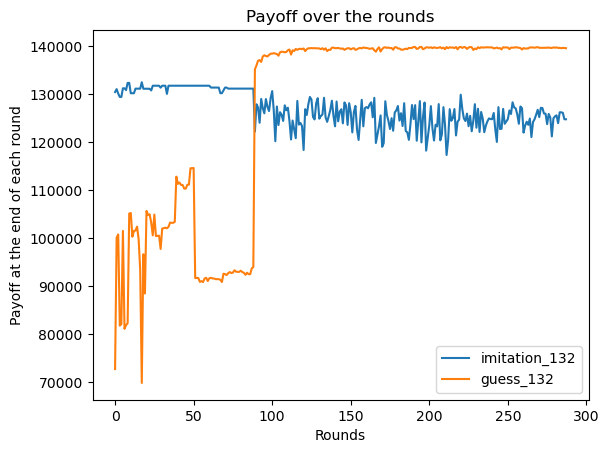

In [9]:
for index, adversary_probability in enumerate(adversary_probabilities):
        if adversary_probability > 0:
            plt.plot(opponent_results[index])
legend = list()
for index, adversary in enumerate(AdversaryModes):
    if adversary_probabilities[index] > 0:
        legend.append(adversary.name)
plt.title("Payoff over the rounds")
plt.xlabel("Rounds")
plt.ylabel("Payoff at the end of each round")
plt.legend(legend)

In [10]:
name = ""
for index, adversary in enumerate(AdversaryModes):
    if adversary_probabilities[index] > 0:
        if name != "":
            name += "_"
        name += str(adversary_probabilities[index]) + "_" + adversary.name

In [11]:
excel_name = name + ".xlsx"
writer = pd.ExcelWriter(excel_name, engine='xlsxwriter')
for index, adversary in enumerate(AdversaryModes):
    if adversary_probabilities[index] > 0:
        df = pd.DataFrame(opponent_results[index])
        name = "Payoff against " + adversary.name
        df.to_excel(writer, sheet_name= name, index=False)
writer.save()
Qtable.save(name)

In [12]:
# We now have the trained agent. We want to test it against each opponent individually, so that
# we can compare it against the agent that is just trained against this opponent.

In [13]:
for index, adversary in enumerate(AdversaryModes):
    if adversary_probabilities[index] > 0:
        new_adversary_probabilities =[0]*len(AdversaryModes)
        new_adversary_probabilities[index] = 1
        result = Test(game, Qtable, discount_factor, new_adversary_probabilities)
        payoff, adversary_payoff, actions, adversary_actions, demand_potential = result.total_payoff()
        print("Adversary Name:", adversary.name)
        print("Agent Payoff:", payoff, "Adversary Payoff:", adversary_payoff)
        print("Agent Actions:", actions)
        print("Adversary Actions:", adversary_actions)
        print("Agent Demand Potential:", demand_potential)

Adversary Name: imitation_132
Agent Payoff: 124717.0 Adversary Payoff: 72285.0
Agent Actions: [118 132 117 109 108 111  90 113 107 105 100 106 104  99  97  95  91 106
 103  98 102 102 100 114 130]
Adversary Actions: [132 118 132 117 109 108 111  90 113 107 105 100 106 104  99  97  95  91
 106 103  98 102 102 100 114]
Agent Demand Potential: [200. 207. 200. 207. 211. 211. 209. 219. 207. 210. 211. 213. 210. 211.
 213. 214. 215. 217. 209. 210. 212. 210. 210. 211. 204.]
Adversary Name: guess_132
Agent Payoff: 139529.0 Adversary Payoff: 92466.0
Agent Actions: [118 132 132 132 132 132 132 132 132 132 132 132 132 132 128 126 129 119
 123 123 123 123 124 112 135]
Adversary Actions: [132 132 132 132 132 132 132 132 132 132 132 132 132 132 132 124 124 124
 124 124 124 124 124 124 129]
Agent Demand Potential: [200. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207. 207.
 207. 209. 208. 205. 207. 207. 207. 207. 207. 207. 213.]
